In [1]:
import msprime, tskit, pyslim, time 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os
import re

In [2]:
plt.rcParams['lines.markersize'] = 18

In [ ]:
#Testing kasper stats
import kasper_stats
for s in ["A_3__N_1000__u_0.0000050000__r_0.0000000005__S_20_0.trees", "A_3__N_1000__u_0.0000050000__r_0.0000000005__S_20_3.trees", "A_3__N_1000__u_0.0000050000__r_0.0000000500__S_20_3.trees", "A_3__N_1000__u_0.0000050000__r_0.0000000500__S_20_3.trees"]:
    ts = tskit.load("../steps/processed_tree_seqs/" + s)
    run_stat_logp = kasper_stats.kasper_run_stat(ts)
    plt.scatter(list(range(len(run_stat_logp))), run_stat_logp, s = 1)
    plt.show()

In [2]:
#Creating merged dataframe from h5 files
dir = "../steps/processed_tree_seqs/"
files = os.listdir(dir)
tables = [f for f in files if f.endswith('.h5')]
dfs = [pd.read_hdf(dir + s) for s in tables]
merged_df = pd.concat(dfs)
merged_df["Diversity"] =  -np.log10(merged_df["Diversity"]) #this is to make diversity more evident in the graph
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True) #Filtering non informing values
merged_df = merged_df.dropna()
merged_df

/home/davidec/miniconda3/envs/birc-project/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Position,Diversity,Branch Length,Tajima's D,A,N,u,r,S
3,1001.0,3.597913,72668.0,-0.285801,3.0,1000.0,0.000005,5.000000e-08,2.0
4,1485.0,4.414648,72838.0,-0.893303,3.0,1000.0,0.000005,5.000000e-08,2.0
6,2003.0,2.112269,87226.0,1.178270,3.0,1000.0,0.000005,5.000000e-08,2.0
8,5774.0,3.700094,87726.0,1.269913,3.0,1000.0,0.000005,5.000000e-08,2.0
9,10364.0,3.927553,87442.0,0.123557,3.0,1000.0,0.000005,5.000000e-08,2.0
...,...,...,...,...,...,...,...,...,...
72,28827729.0,3.937643,82006.0,0.225589,3.0,1000.0,0.000005,5.000000e-10,2.0
73,28922854.0,3.805304,82019.0,0.386153,3.0,1000.0,0.000005,5.000000e-10,2.0
75,29331450.0,3.764248,84234.0,0.518134,3.0,1000.0,0.000005,5.000000e-10,2.0
76,29542231.0,3.762825,83645.0,0.220404,3.0,1000.0,0.000005,5.000000e-10,2.0


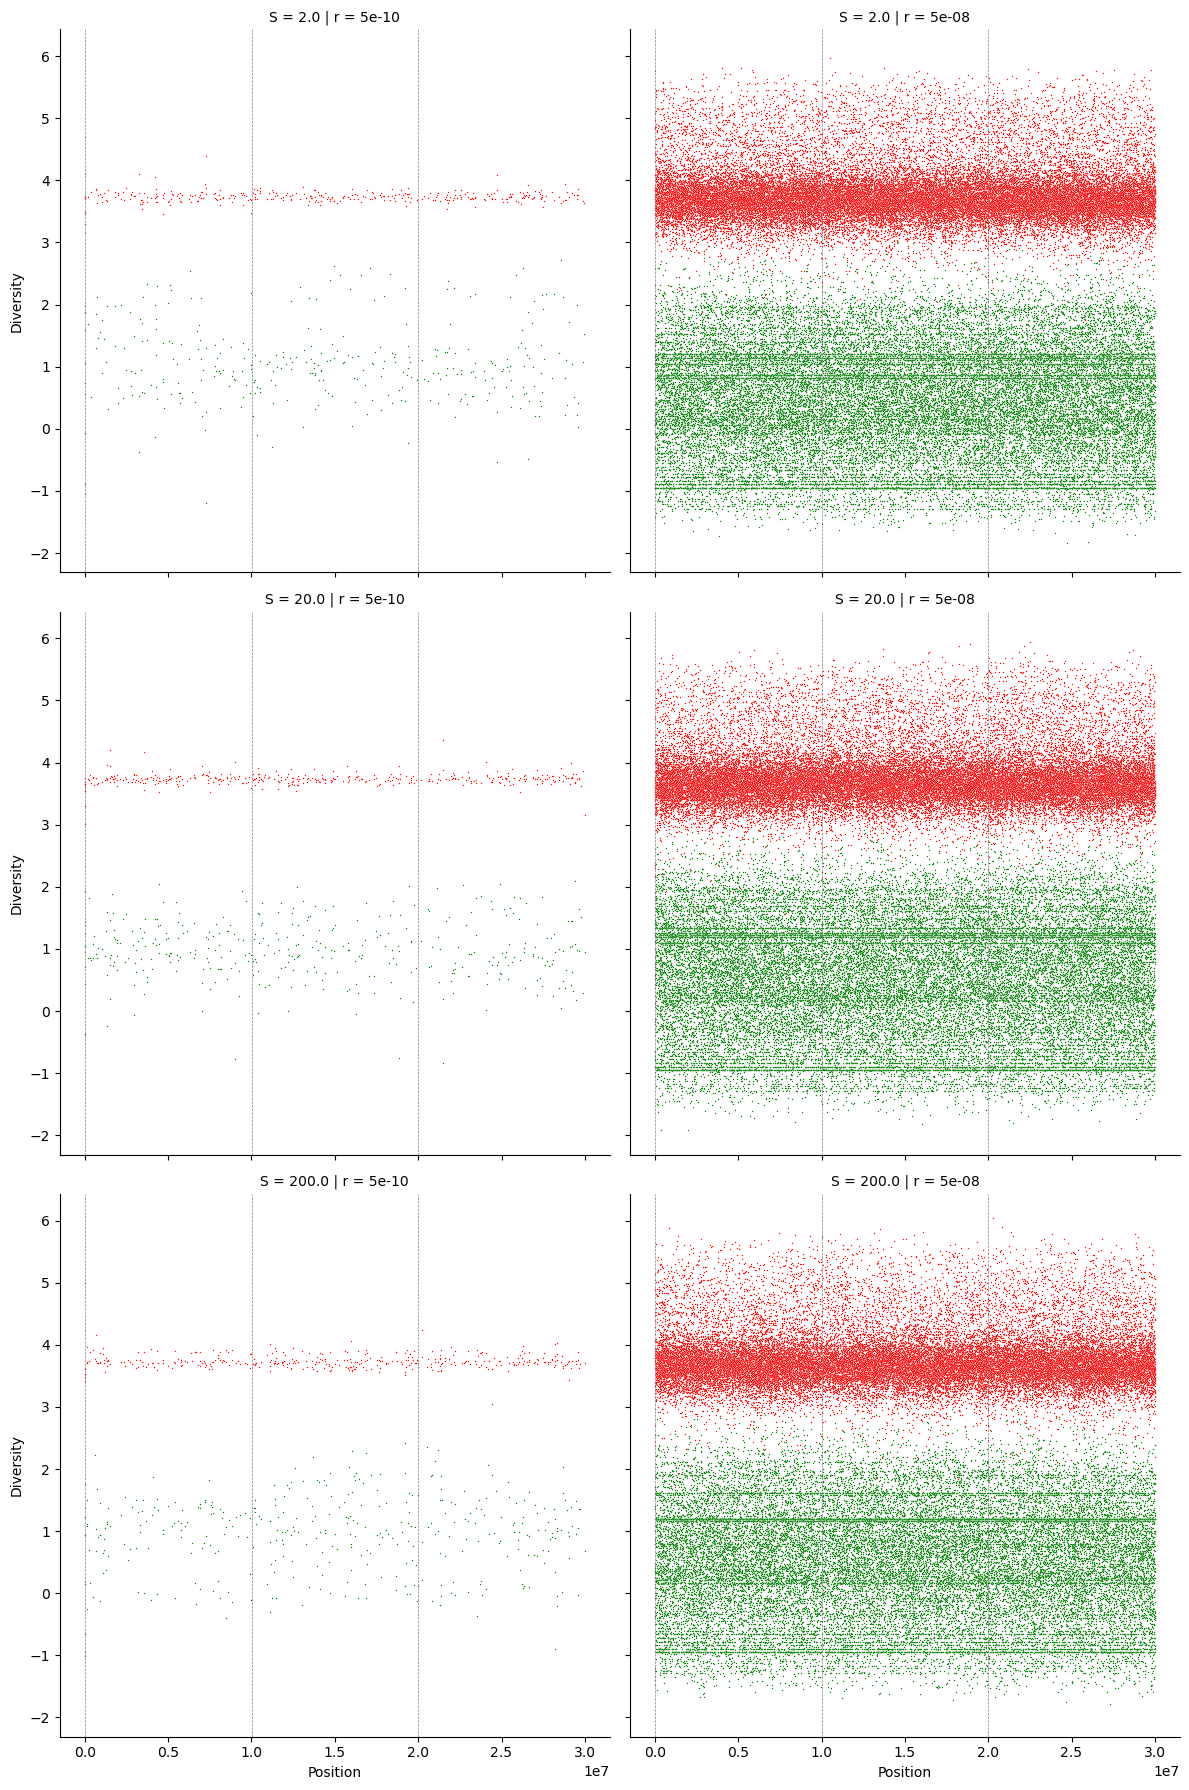

In [3]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)] #(start, end) of amplicon genomic position intervals
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals] #average of amplicon positions
#Seaborn FacetGrid plot
g = sns.FacetGrid(merged_df, col="r", row="S", height=6)
g.map(sns.scatterplot, "Position", 'Tajima\'s D', s=1, color = "green")
g.map(sns.scatterplot, "Position", 'Diversity', s = 1, color = "red")
#g.map(sns.scatterplot, "Position", 'Branch Length', s = 2, color = "blue")
for axs in g.axes:
        for vline in amplicon_average_positions:
                axs[0].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
                axs[1].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
g.tight_layout()

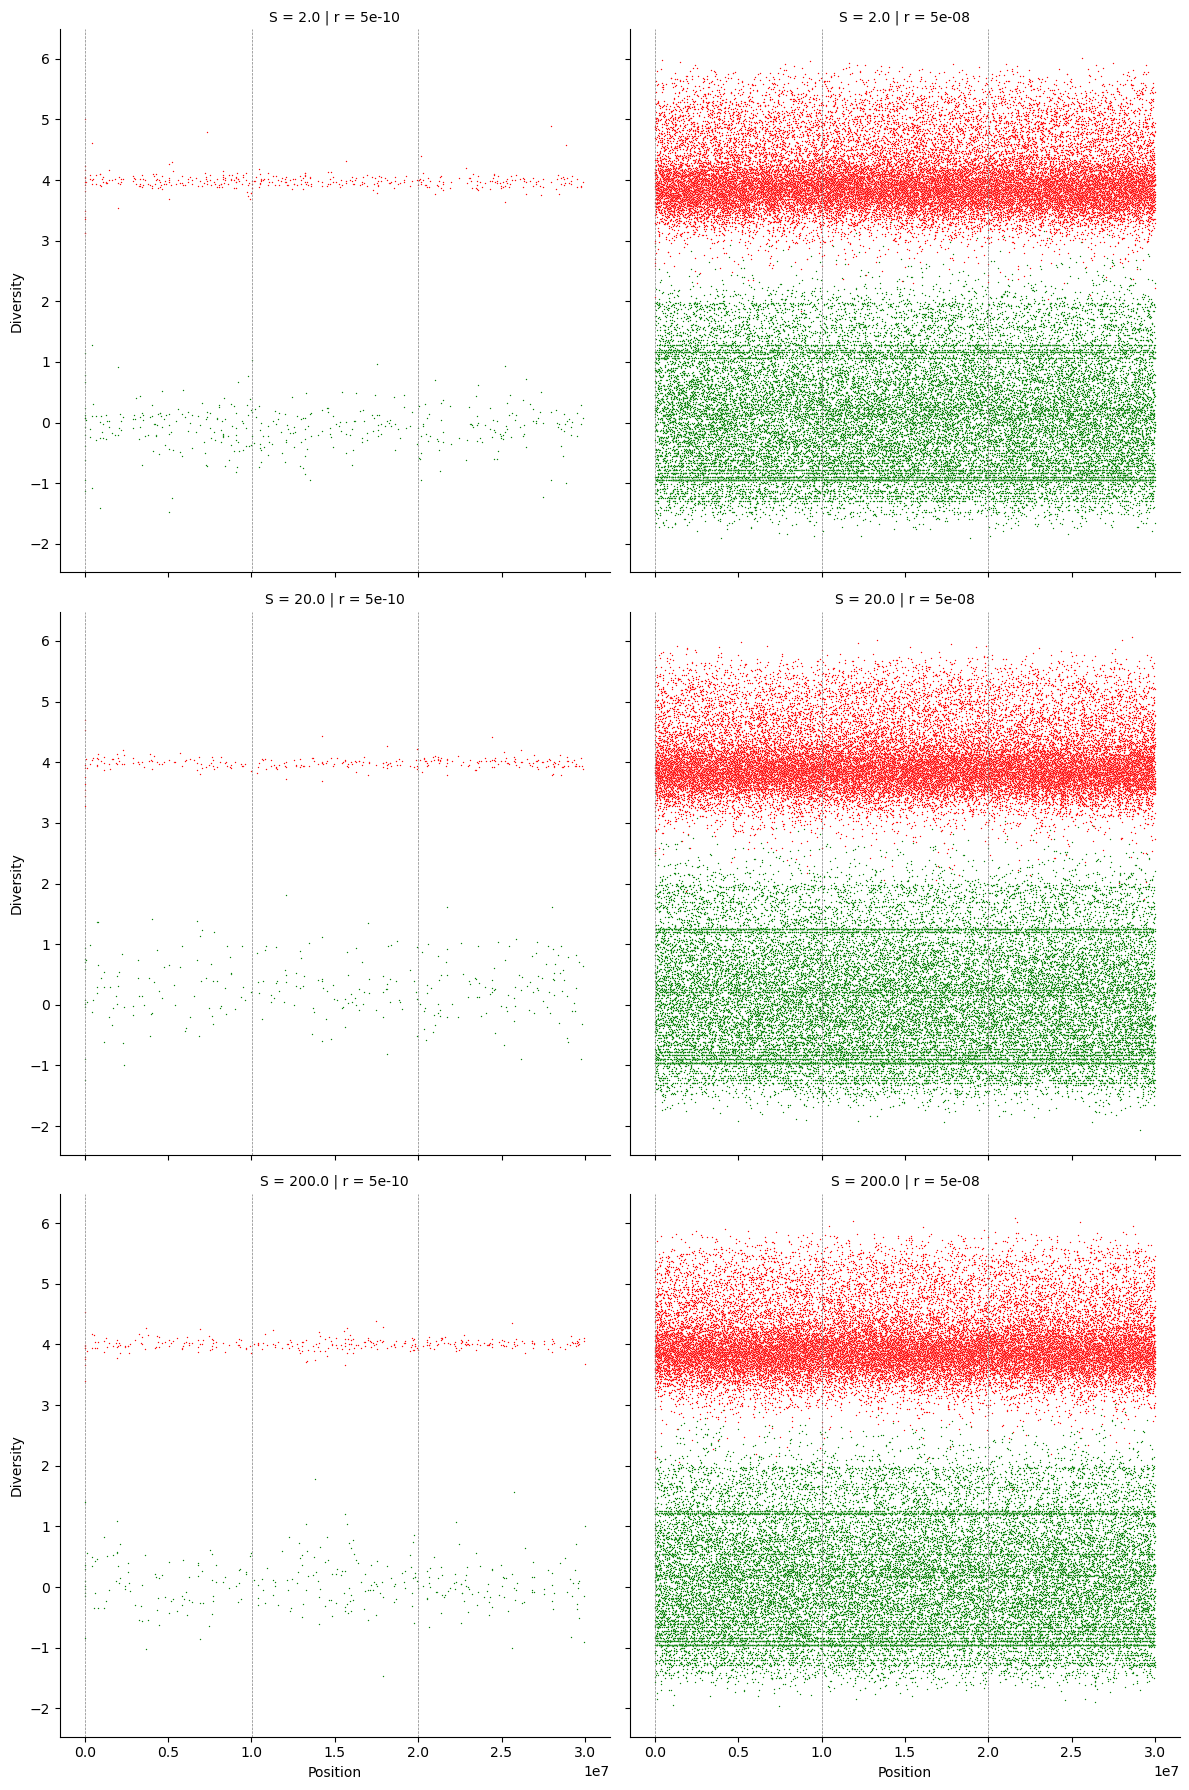

In [36]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)]
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals]

g = sns.FacetGrid(merged_df, col="r", row="S", height=6)
g.map(sns.scatterplot, "Position", 'Tajima\'s D', s = 1, color = "green")
g.map(sns.scatterplot, "Position", 'Diversity', s = 1, color = "red")
#g.map(sns.scatterplot, "Position", 'Branch Length', s = 2, color = "blue")
for axs in g.axes:
        for vline in amplicon_average_positions:
                axs[0].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
                axs[1].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
g.tight_layout()

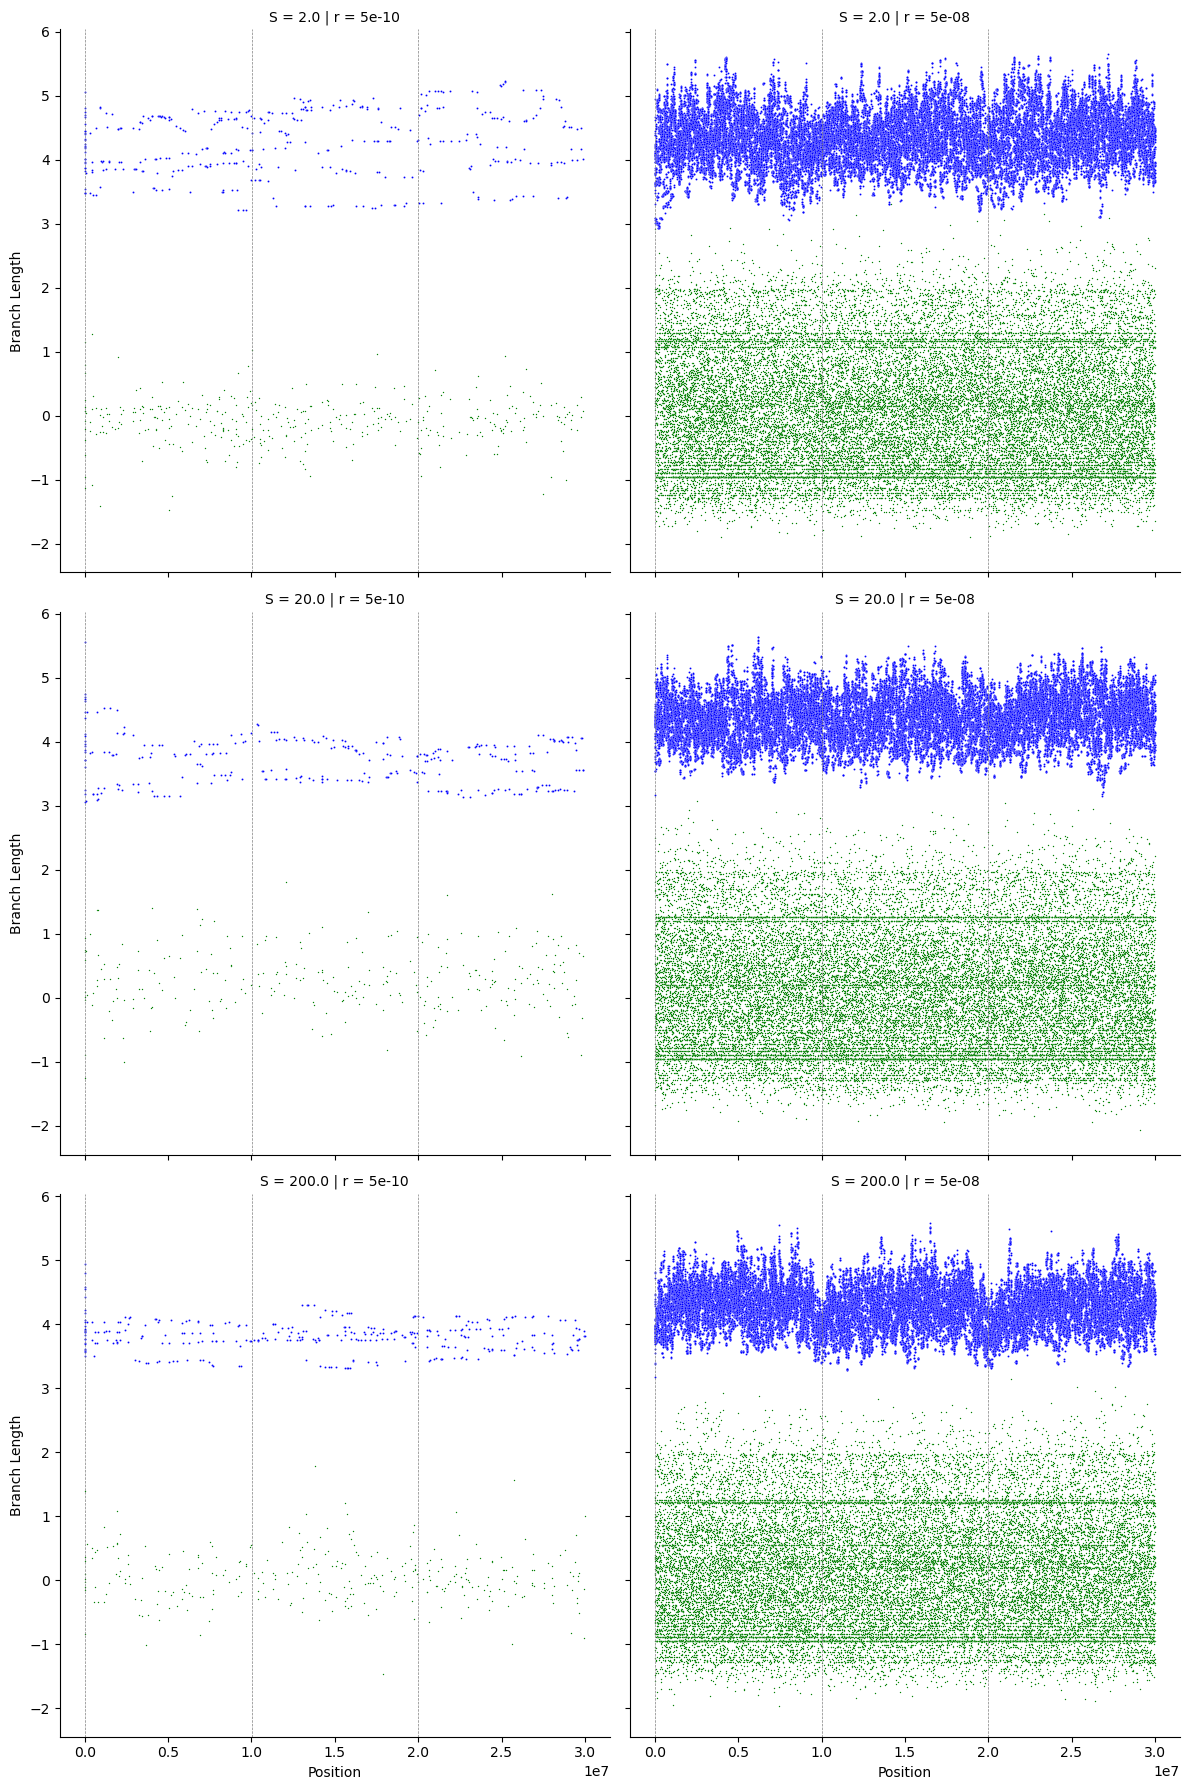

In [47]:
g = sns.FacetGrid(merged_df, col="r", row="S", height=6)
g.map(sns.scatterplot, "Position", 'Tajima\'s D', s = 1, color = "green")
#g.map(sns.scatterplot, "Position", 'Diversity', s = 1, color = "red")
g.map(sns.scatterplot, "Position", 'Branch Length', s = 2, color = "blue")
for axs in g.axes:
        for vline in amplicon_average_positions:
                axs[0].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
                axs[1].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
g.tight_layout()

In [1]:
def ts_file_to_df(ts_file):
    params = [c for c in ts_file.split("/")[-1].split("_")[:-1] if c != ""] #getting params from file name
    params_dict = dict(zip(params[::2], map(float, params[1::2])))
    ts = tskit.load(ts_file)
    windows = list(ts.breakpoints())
    diversity = ts.diversity(windows=windows, mode='site')
    branch_length = [tree.total_branch_length for tree in ts.trees()]
    tajimas_D = ts.Tajimas_D(windows=windows)
    df = pd.DataFrame({
        'Position': windows[:-1],
        'Diversity': diversity,
        'Branch Length': branch_length,
        'Tajima\'s D': tajimas_D,
        **params_dict
}, index=[i + 1 for i in range(len(ts.trees()))])
    return df 


In [4]:
dir = "../steps/slim_tree_seqs/"
files = os.listdir(dir)
treeseqs_files = [f for f in files if f.endswith('.trees')]
dfs = [ts_file_to_df(dir + ts) for ts in treeseqs_files]
merged_df = pd.concat(dfs)
merged_df["Diversity"] =  -np.log10(merged_df["Diversity"]) #this is to make diversity more evident in the graph
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df = merged_df.dropna()
merged_df

/home/davidec/miniconda3/envs/birc-project/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Position,Diversity,Branch Length,Tajima's D,A,N,u,r,S
5,2003.0,2.345851,104410.0,0.972432,3.0,1000.0,0.000005,5.000000e-10,20.0
44,9576773.0,4.639758,104372.0,1.061357,3.0,1000.0,0.000005,5.000000e-10,20.0
76,19561065.0,4.851136,105234.0,1.201499,3.0,1000.0,0.000005,5.000000e-10,20.0
115,29858379.0,5.671378,105543.0,1.184532,3.0,1000.0,0.000005,5.000000e-10,20.0
7,2003.0,2.299374,103916.0,1.223170,3.0,1000.0,0.000005,5.000000e-08,2.0
...,...,...,...,...,...,...,...,...,...
12791,30002977.0,3.813136,108368.0,1.180294,3.0,1000.0,0.000005,5.000000e-08,2.0
5,2003.0,4.493162,93811.0,1.299851,3.0,1000.0,0.000005,5.000000e-10,2.0
40,9805157.0,4.413353,97233.0,0.715509,3.0,1000.0,0.000005,5.000000e-10,2.0
76,19389840.0,4.956196,96861.0,2.039082,3.0,1000.0,0.000005,5.000000e-10,2.0


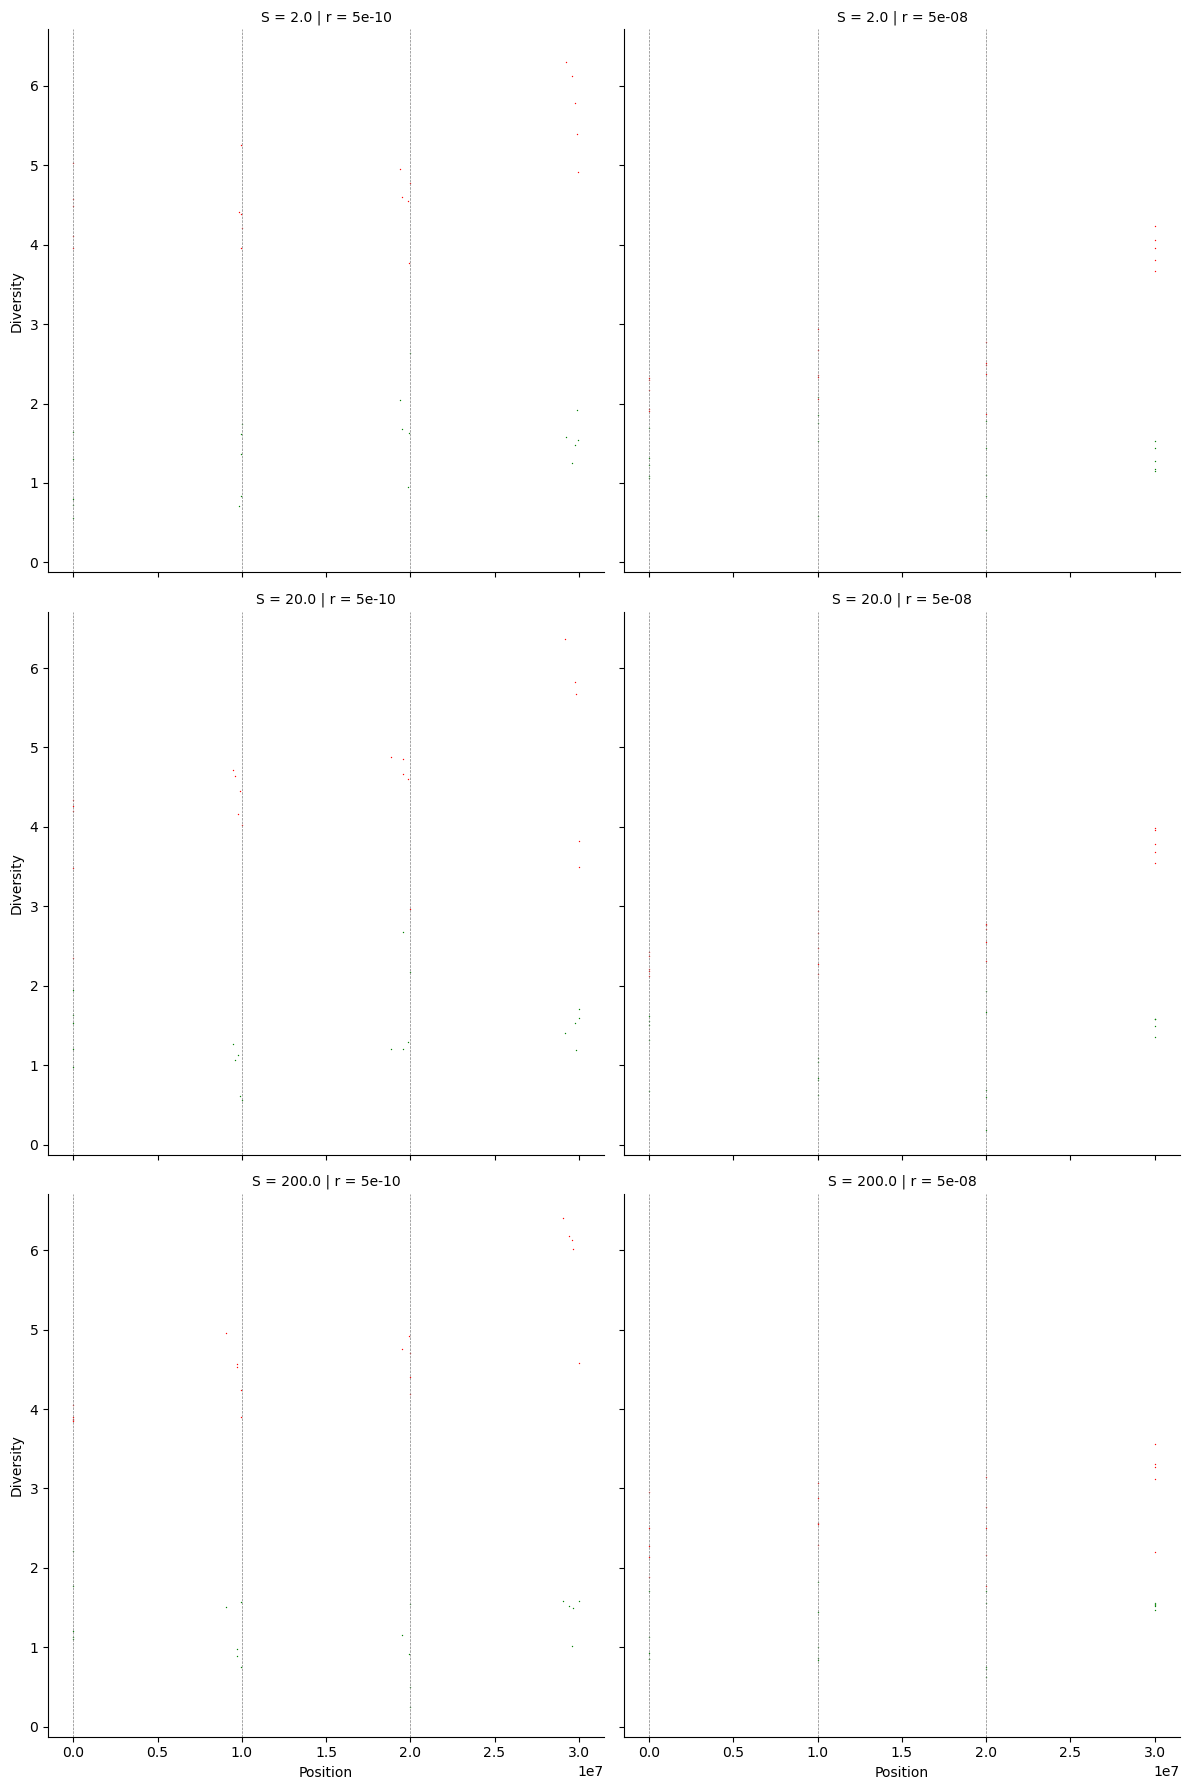

In [5]:
amplicon_intervals = [(2003, 3003), (10003003, 10004003), (20004003, 20005003)]
amplicon_average_positions = [(sum(e) // 2) for e in amplicon_intervals]
g = sns.FacetGrid(merged_df, col="r", row="S", height=6)
g.map(sns.scatterplot, "Position", 'Tajima\'s D', s = 1, color = "green")
g.map(sns.scatterplot, "Position", 'Diversity', s = 1, color = "red")
#g.map(sns.scatterplot, "Position", 'Branch Length', s = 2, color = "blue")
for axs in g.axes:
        for vline in amplicon_average_positions:
                axs[0].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
                axs[1].axvline(x = vline, color='grey', linestyle='--', lw = 0.5)
g.tight_layout()

In [2]:
def rts_file_to_df(ts_file):
    ts = tskit.load(ts_file)
    windows = list(ts.breakpoints())
    diversity = ts.diversity(windows=windows, mode='site')
    branch_length = [tree.total_branch_length for tree in ts.trees()]
    tajimas_D = ts.Tajimas_D(windows=windows)
    df = pd.DataFrame({
        'Position': windows[:-1],
        'Diversity': diversity,
        'Branch Length': branch_length,
        'Tajima\'s D': tajimas_D,
}, index=[i + 1 for i in range(len(ts.trees()))])
    return df 

In [6]:
dir = "../data/slim_193886122_FIXED.trees"
df = rts_file_to_df(dir)
#merged_df["Diversity"] =  -np.log10(merged_df["Diversity"]) #this is to make diversity more evident in the graph
#merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df = df.dropna()
merged_df

,Position,Diversity,Branch Length,Tajima's D
4,15060.0,0.000003,13968.0,-0.957253
5,29594.0,0.000002,13972.0,-1.038369
6,39198.0,0.000006,13973.0,-0.647653
7,44063.0,0.000004,13970.0,-1.353754
